## Algorithm Explained
- First read file using pandas and store contents in a dictionary.
- Second implement a function to find the minimum cost for a single vertex keeping consistency in mind (i.e each child precedes parent nodes).
- Third, run the desired search algorithm (bfs, dfs ucs) by passing the initial state space as empty vertices and the costs dictionary.
- The search algorithm will call the minimum consistent cost function to calculate the shortest ordering and minimum cost and print cost and path.
- Lastly, using the ordering and minimum costs, construct a graph using networkx to visualize the shortest ordering.

In [1]:
# reading from a file

import pandas as pd
import re

# Defining the column names
column_names = ["vertex", "parent", "cost"]

# Inititalizing to collect the rows
rows = []

with open("data0.txt", "r") as file:
    for line in file:

        # This regex captures the numbers outside the brackets as separate groups and the entire bracket expression as one group
        match = re.match(r"(\d+),(\{.*?\}),([\d\.]+)", line)
        if match:
            # Appending the groups found by the regex as a new row in list
            rows.append(match.groups())

# Creating DataFrame from rows
vertices_dataset = pd.DataFrame(rows, columns=column_names)

# Converting the 'cost' column to float

# vertices_dataset['vertex'] = vertices_dataset['vertex'].astype(int)
vertices_dataset['cost'] = vertices_dataset['cost'].astype(float)

print(vertices_dataset)


   vertex parent     cost
0       1     {}  153.466
1       1    {3}   96.093
2       1    {4}   97.913
3       1    {5}   99.835
4       2     {}  141.023
5       2    {3}  122.446
6       2    {4}  121.576
7       2    {5}  123.398
8       3     {}  169.482
9       3    {1}  112.109
10      3    {2}  150.906
11      3  {1,2}  107.516
12      3    {4}   51.681
13      3    {5}   41.775
14      4     {}  169.482
15      4    {1}  113.929
16      4    {2}  150.036
17      4  {1,2}  108.982
18      4    {3}   51.681
19      4    {5}   36.188
20      5     {}  169.802
21      5    {1}  116.171
22      5    {2}  152.178
23      5  {1,2}  111.473
24      5    {3}   42.096
25      5    {4}   36.508


In [2]:
# Converting 'vertex' to int, 'parent' to a set, and 'cost' to float
vertices_dataset['vertex'] = vertices_dataset['vertex'].astype(int)
vertices_dataset['cost'] = vertices_dataset['cost'].astype(float)
vertices_dataset['parent'] = vertices_dataset['parent'].apply(lambda x: tuple(map(int, x.strip('{}').split(','))) if x.strip('{}') else ())

# dictionary to hold the costs where each key is a vertex and each value is a list of tuples with parent sets and costs
costs = {}

# Iterating over the DataFrame rows to fill the dictionary
for index, row in vertices_dataset.iterrows():
    vertex = row['vertex']
    parent_set = row['parent']
    cost = row['cost']

    # Adding the data
    if vertex not in costs:
        costs[vertex] = []
    costs[vertex].append((parent_set, cost))

print(costs)
all_vertices = len(costs.keys())
print(all_vertices)

{1: [((), 153.466), ((3,), 96.093), ((4,), 97.913), ((5,), 99.835)], 2: [((), 141.023), ((3,), 122.446), ((4,), 121.576), ((5,), 123.398)], 3: [((), 169.482), ((1,), 112.109), ((2,), 150.906), ((1, 2), 107.516), ((4,), 51.681), ((5,), 41.775)], 4: [((), 169.482), ((1,), 113.929), ((2,), 150.036), ((1, 2), 108.982), ((3,), 51.681), ((5,), 36.188)], 5: [((), 169.802), ((1,), 116.171), ((2,), 152.178), ((1, 2), 111.473), ((3,), 42.096), ((4,), 36.508)]}
5


In [3]:
def calculate_minConsistentCost(vertex, ordering, costs_dict):
    valid_parent_sets = [p_set for p_set, cost in costs_dict[vertex] if set(p_set).issubset(set(ordering[:ordering.index(vertex)]))]
    if not valid_parent_sets:  # If there are no valid parent sets, return infinity or a very large number
        return float('inf')
    return min(cost for p_set, cost in costs_dict[vertex] if p_set in valid_parent_sets)


In [4]:
# helper functions to be used in Searching
def is_complete(ordering, costs_dict):

  return len(ordering) == len(costs_dict.keys())

def get_available_vertices(ordering, costs_dict):

  # Gets a list of vertices not in the ordering.
  all_vertices = list(costs_dict.keys())
  available_vertices = set(all_vertices) - set(ordering)
  return list(available_vertices)

def calculate_total_cost(ordering, costs_dict):

  # Calculates the total cost of the ordering.
  total_cost = 0
  for vertex in ordering:
        # Calling the minConsistenCost function for each vertex in the ordering
        mcc_cost = calculate_minConsistentCost(vertex, ordering, costs_dict)
        total_cost = total_cost + mcc_cost
  return total_cost

In [6]:
from queue import Queue

def bfs(initial_state, costs_dict):
  # initial_state: The initial ordering (empty list).

  queue = Queue()
  queue.put(initial_state)
  minimum_cost = float('inf')
  optimal_ordering = None

  while not queue.empty():
    # Get first ordering from the queue
    ordering = queue.get()

    # If the ordering is complete, then updating the minimum cost and optimal ordering
    if is_complete(ordering, costs_dict):
      total_cost = calculate_total_cost(ordering, costs_dict)
      if total_cost < minimum_cost:
        minimum_cost = total_cost
        optimal_ordering = ordering
    else:
      # For each vertex not in the ordering, add it in all possible positions and enqueue
      for vertex in get_available_vertices(ordering, costs_dict):
        for i in range(len(ordering) + 1):
          new_ordering = ordering.copy()
          new_ordering.insert(i, vertex)
          queue.put(new_ordering)

  return minimum_cost, optimal_ordering

In [7]:
initial_state = [] # empty ordering
min_cost_bfs, optimal_ordering_bfs = bfs(initial_state, costs)
print("Minimum cost using BFS:", min_cost_bfs)
print("Optimal ordering using BFS:", optimal_ordering_bfs)

Minimum cost using BFS: 465.43399999999997
Optimal ordering using BFS: [4, 2, 5, 3, 1]


In [8]:
import networkx as nx

def generate_graph(ordering, costs_dict):

    graph = nx.DiGraph()  # to represent directed graph

    # Adding vertices
    for vertex in ordering:
        graph.add_node(vertex)

    # Adding edges with weights based on parent set costs
    for i, vertex in enumerate(ordering):
        # Finding the minimum consistent cost parent set within the ordering
        min_cost = float('inf')
        min_cost_parent_set = ()
        for parent_set, cost in costs_dict[vertex]:
          # checking if the first i elements of ordering are present in parent_set
            if set(parent_set).issubset(set(ordering[:i])):
                if cost < min_cost:
                    min_cost = cost
                    min_cost_parent_set = parent_set

        # If there's a valid parent set, add an edge for each parent in the set
        if min_cost_parent_set:
            for parent in min_cost_parent_set:
                graph.add_edge(parent, vertex, weight=min_cost)

    return graph

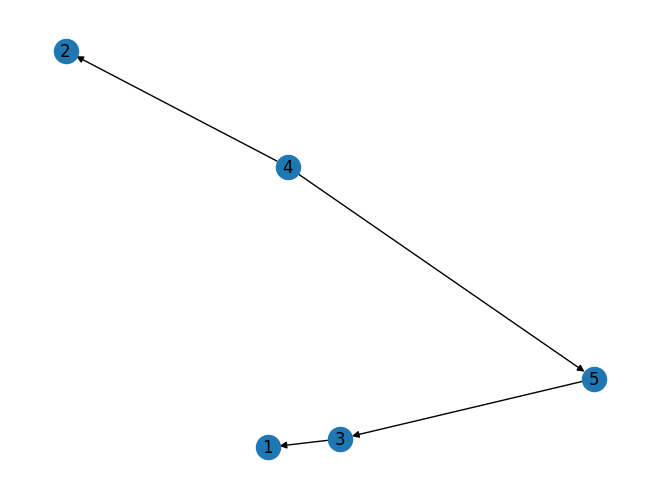

In [10]:
graph = generate_graph(optimal_ordering_bfs, costs)

# Draw the graph
nx.draw(graph, with_labels=True)

In [11]:
def dfs(initial_state, costs_dict):

    stack = [initial_state]  # Use a list as a stack for DFS
    minimum_cost = float('inf')
    optimal_ordering = None

    while stack:
        # Popping the last ordering from the stack
        ordering = stack.pop()

        # If the ordering is complete, update the minimum cost and optimal ordering
        if is_complete(ordering, costs_dict):
            total_cost = calculate_total_cost(ordering, costs_dict)
            if total_cost < minimum_cost:
                minimum_cost = total_cost
                optimal_ordering = ordering
        else:
            # For each vertex not in the ordering, add it in all possible positions and stack
            for vertex in get_available_vertices(ordering, costs_dict):
                for i in range(len(ordering) + 1):
                    new_ordering = ordering.copy()
                    new_ordering.insert(i, vertex)
                    stack.append(new_ordering)

    return minimum_cost, optimal_ordering

In [12]:
optimal_cost_dfs, optimal_ordering_dfs = dfs([], costs)
print("Optimal Cost using DFS:", optimal_cost_dfs)
print("Optimal Ordering using DFS:", optimal_ordering_dfs)

Optimal Cost using DFS: 465.43399999999997
Optimal Ordering using DFS: [5, 4, 3, 1, 2]


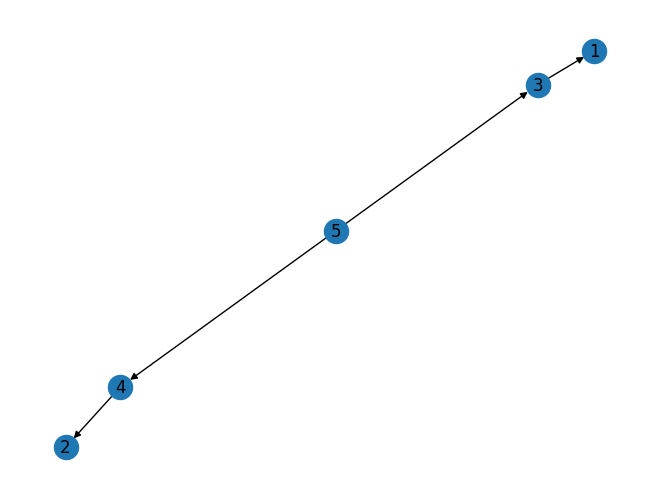

In [14]:
graph = generate_graph(optimal_ordering_dfs, costs)

# Draw the graph
nx.draw(graph, with_labels=True)

In [15]:
import heapq  # for priority queue functionality

def ucs(initial_state, costs_dict):

    # Initializing the priority queue with the initial state and initial cost of 0
    priority_queue = [(0, initial_state)]  # (cost, ordering)
    minimum_cost = float('inf')
    optimal_ordering = None

    while priority_queue:
        # Popping the ordering with the lowest cost from the priority queue
        current_cost, ordering = heapq.heappop(priority_queue)

        # If the ordering is complete, update the minimum cost and optimal ordering
        if is_complete(ordering, costs_dict):
            if current_cost < minimum_cost:
                minimum_cost = current_cost
                optimal_ordering = ordering
        else:
            # For each vertex not in the ordering, add it in all possible positions and enqueue with updated cost
            for vertex in get_available_vertices(ordering, costs_dict):
                for i in range(len(ordering) + 1):
                    new_ordering = ordering.copy()
                    new_ordering.insert(i, vertex)
                    # Calculating the new total cost for the new ordering
                    new_total_cost = calculate_total_cost(new_ordering, costs_dict)
                    # Adding the new ordering and its cost to the priority queue
                    heapq.heappush(priority_queue, (new_total_cost, new_ordering))

    return minimum_cost, optimal_ordering

In [16]:
optimal_cost_ucs, optimal_ordering_ucs = ucs([], costs)
print("Optimal Cost using UCS:", optimal_cost_ucs)
print("Optimal Ordering using UCS:", optimal_ordering_ucs)

Optimal Cost using UCS: 465.43399999999997
Optimal Ordering using UCS: [4, 2, 5, 3, 1]


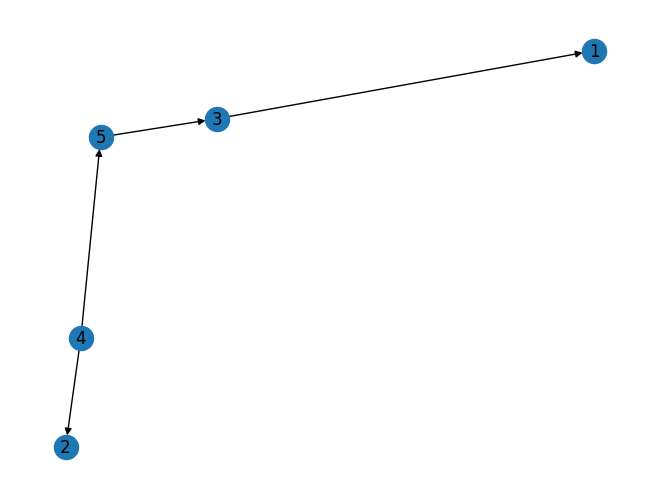

In [19]:
graph = generate_graph(optimal_ordering_ucs, costs)

# Draw the graph
nx.draw(graph, with_labels=True)